In [ ]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [ ]:
!mkdir -p ./data/MNIST/raw
batch_size = 128
transform = transforms.ToTensor()

!wget -O ./data/MNIST/raw/train-images-idx3-ubyte.gz https://github.com/fgnt/mnist/raw/master/train-images-idx3-ubyte.gz
!wget -O ./data/MNIST/raw/train-labels-idx1-ubyte.gz https://github.com/fgnt/mnist/raw/master/train-labels-idx1-ubyte.gz
!wget -O ./data/MNIST/raw/t10k-images-idx3-ubyte.gz https://github.com/fgnt/mnist/raw/master/t10k-images-idx3-ubyte.gz
!wget -O ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz https://github.com/fgnt/mnist/raw/master/t10k-labels-idx1-ubyte.gz

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

--2025-09-22 05:09:38--  https://github.com/fgnt/mnist/raw/master/train-images-idx3-ubyte.gz
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/fgnt/mnist/master/train-images-idx3-ubyte.gz [following]
--2025-09-22 05:09:38--  https://raw.githubusercontent.com/fgnt/mnist/master/train-images-idx3-ubyte.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9912422 (9.5M) [application/octet-stream]
Saving to: ‘./data/MNIST/raw/train-images-idx3-ubyte.gz’

./data/MNIST/raw/tr 100%[===================>]   9.45M  --.-KB/s    in 0.1s    

2025-09-22 05:09:39 (91.8 MB/s) - ‘./data/MNIST/raw/train-images-idx3-u

In [ ]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(784, 400)
        self.fc_mu = nn.Linear(400, 20)
        self.fc_logvar = nn.Linear(400, 20)
        self.fc2 = nn.Linear(20, 400)
        self.fc3 = nn.Linear(400, 784)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc2(z))
        return torch.sigmoid(self.fc3(h))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar



In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [ ]:
for epoch in range(1, 6):
    model.train()
    train_loss = 0
    for data, _ in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        recon, mu, logvar = model(data)
        loss = loss_function(recon, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(f"Epoch {epoch}, 平均 Loss: {train_loss / len(train_loader.dataset):.4f}")

Epoch 1, 平均 Loss: 164.0191
Epoch 2, 平均 Loss: 121.3956
Epoch 3, 平均 Loss: 114.5754
Epoch 4, 平均 Loss: 111.6591
Epoch 5, 平均 Loss: 109.9060


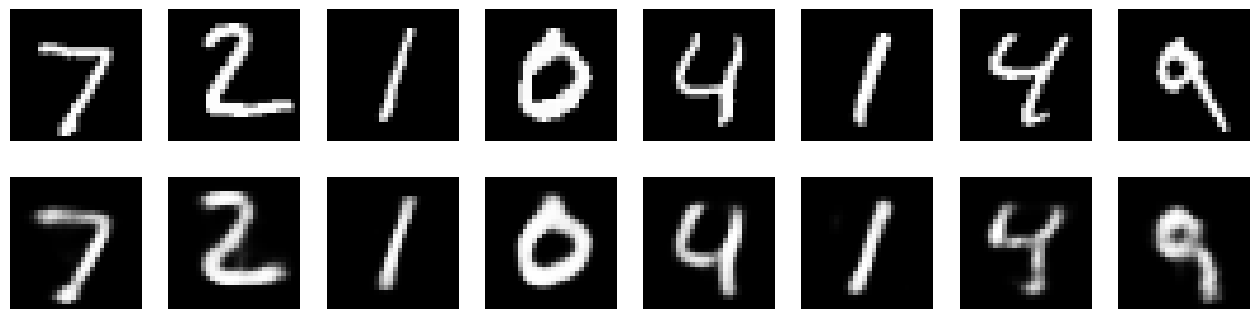

In [ ]:
model.eval()
with torch.no_grad():
    data, _ = next(iter(test_loader))
    data = data.to(device)
    recon, _, _ = model(data)

    n = 8
    plt.figure(figsize=(16, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(data[i].cpu().view(28, 28), cmap="gray")
        ax.axis("off")

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(recon[i].cpu().view(28, 28), cmap="gray")
        ax.axis("off")
    plt.show()